# Word Vectors with corpora (W2V TF TB) TEMPLATE

# Imports

In [1]:
# future is the missing compatibility layer between Python 2 and Python 3. 
# It allows you to use a single, clean Python 3.x-compatible codebase to 
# support both Python 2 and Python 3 with minimal overhead.

from __future__ import absolute_import, division, print_function

In [16]:
# encoding, word encoding
import codecs
# finds all pathnames matching a pattern, like regex
import glob
# log events for libraries
import logging
# concurrency
import multiprocessing
# dealing with operating system , like reading file
import os
# pretty print, human readable
import pprint
# regular expressions
import re

In [2]:
# natural language toolkit
import nltk
# word 2 vec
import gensim.models.word2vec as w2v
# dimensionality reduction
import sklearn.manifold
# math
import numpy as np
# plotting
import matplotlib.pyplot as plt
# parse dataset
import pandas as pd
# visualization
import seaborn as sns

In [18]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [19]:
# Set up logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [20]:
# Download NLTK tokenizer models (only the first time)
# stopwords like the at a an, unnecessary
# tokenization into sentences, punkt 
# http://www.nltk.org/
# however, no model for Chinese found in the nltk package
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/fgbxub/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/fgbxub/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Prepare Corpus

In [21]:
# Load corpus files,
# get the file names, matching txt file
book_filenames = sorted(glob.glob("/home/fgbxub/Desktop/W2V-20190719/data/*.txt"))

In [22]:
# Print files names
print("Found books:")
book_filenames

Found books:


['/home/fgbxub/Desktop/W2V-20190719/data/13_1997_E_raw.txt',
 '/home/fgbxub/Desktop/W2V-20190719/data/13_1998_E_raw.txt',
 '/home/fgbxub/Desktop/W2V-20190719/data/13_1999_E_raw.txt',
 '/home/fgbxub/Desktop/W2V-20190719/data/13_2000_E_raw.txt',
 '/home/fgbxub/Desktop/W2V-20190719/data/13_2001_E_raw.txt',
 '/home/fgbxub/Desktop/W2V-20190719/data/13_2002_E_raw.txt',
 '/home/fgbxub/Desktop/W2V-20190719/data/13_2003_E_raw.txt',
 '/home/fgbxub/Desktop/W2V-20190719/data/13_2004_E_raw.txt',
 '/home/fgbxub/Desktop/W2V-20190719/data/13_2005_E_raw.txt',
 '/home/fgbxub/Desktop/W2V-20190719/data/13_2006_E_raw.txt',
 '/home/fgbxub/Desktop/W2V-20190719/data/13_2007_E_raw.txt',
 '/home/fgbxub/Desktop/W2V-20190719/data/13_2008_E_raw.txt',
 '/home/fgbxub/Desktop/W2V-20190719/data/13_2009_E_raw.txt',
 '/home/fgbxub/Desktop/W2V-20190719/data/13_2010_E_raw.txt',
 '/home/fgbxub/Desktop/W2V-20190719/data/13_2012_E_raw.txt',
 '/home/fgbxub/Desktop/W2V-20190719/data/13_2013_E_raw.txt',
 '/home/fgbxub/Desktop/W

In [23]:
# Combine the books into one string
# step 1, process data

# initialize rawunicode , we'll add all text to this one big file in memory
corpus_raw = u""
# for each file, read it, open it un utf 8 format, 
# add it to the raw corpus
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading '/home/fgbxub/Desktop/W2V-20190719/data/13_1997_E_raw.txt'...
Corpus is now 10097 characters long

Reading '/home/fgbxub/Desktop/W2V-20190719/data/13_1998_E_raw.txt'...
Corpus is now 20398 characters long

Reading '/home/fgbxub/Desktop/W2V-20190719/data/13_1999_E_raw.txt'...
Corpus is now 31550 characters long

Reading '/home/fgbxub/Desktop/W2V-20190719/data/13_2000_E_raw.txt'...
Corpus is now 37495 characters long

Reading '/home/fgbxub/Desktop/W2V-20190719/data/13_2001_E_raw.txt'...
Corpus is now 43746 characters long

Reading '/home/fgbxub/Desktop/W2V-20190719/data/13_2002_E_raw.txt'...
Corpus is now 51617 characters long

Reading '/home/fgbxub/Desktop/W2V-20190719/data/13_2003_E_raw.txt'...
Corpus is now 60695 characters long

Reading '/home/fgbxub/Desktop/W2V-20190719/data/13_2004_E_raw.txt'...
Corpus is now 68445 characters long

Reading '/home/fgbxub/Desktop/W2V-20190719/data/13_2005_E_raw.txt'...
Corpus is now 76686 characters long

Reading '/home/fgbxub/Desktop/W2V-201

In [24]:
# Split the corpus into sentences
# tokenizastion! saved the trained model here
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# uncomment this code for Spanish language, and comment the previous code line
# tokenizer = nltk.data.load('tokenizers/punkt/spanish.pickle')

In [25]:
# tokenize into sentences
raw_sentences = tokenizer.tokenize(corpus_raw)

In [26]:
# convert into a list of words
# remove unnnecessary, split into words, no hyphens
# split into words
# in Spanish we want to include words with accents, so it can' t just be [^a-zA-Z]:
# http://www.rexegg.com/regex-interesting-character-classes.html

def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw) ## for Spanish: clean = re.sub("[^a-zA-ZáéíñóúüÁÉÍÑÓÚÜ]"," ", raw) ## for Chinese: clean = re.sub("[^\u4E00-\u9FA5]"," ", raw)
    words = clean.split()
    return words

In [27]:
# for each sentece, sentences where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [28]:
# print an example
print(raw_sentences[0])
print(sentence_to_wordlist(raw_sentences[0]))

﻿ 
My Lords and Members of the House of Commons.
['My', 'Lords', 'and', 'Members', 'of', 'the', 'House', 'of', 'Commons']


In [29]:
# count tokens, each one being a sentence
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 21,967 tokens


# Train Word2Vec

In [30]:
# ONCE we have vectors
# step 2 - build model
# 3 main tasks that vectors help with
# DISTANCE, SIMILARITY, RANKING

# build our model, another one is Glove
# define hyperparameters

# Dimensionality of the resulting word vectors.
# more dimensions, more computationally expensive to train
# but also more accurate
# more dimensions = more generalized
num_features = 300

# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
# more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
# rate 0 and 1e-5 
# how often to use
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
# random number generator
# deterministic, good for debugging
seed = 1


In [31]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [32]:
thrones2vec.build_vocab(sentences)

2019-07-19 04:20:56,419 : INFO : collecting all words and their counts
2019-07-19 04:20:56,421 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-07-19 04:20:56,429 : INFO : collected 2516 word types from a corpus of 21967 raw words and 1111 sentences
2019-07-19 04:20:56,430 : INFO : Loading a fresh vocabulary
2019-07-19 04:20:56,434 : INFO : min_count=3 retains 967 unique words (38% of original 2516, drops 1549)
2019-07-19 04:20:56,435 : INFO : min_count=3 leaves 20031 word corpus (91% of original 21967, drops 1936)
2019-07-19 04:20:56,514 : INFO : deleting the raw counts dictionary of 2516 items
2019-07-19 04:20:56,516 : INFO : sample=0.001 downsamples 48 most-common words
2019-07-19 04:20:56,517 : INFO : downsampling leaves estimated 12519 word corpus (62.5% of prior 20031)
2019-07-19 04:20:56,558 : INFO : estimated required memory for 967 words and 300 dimensions: 2804300 bytes
2019-07-19 04:20:56,559 : INFO : resetting layer weights


In [33]:
print("Word2Vec vocabulary-length: ", len(thrones2vec.wv.vocab))

Word2Vec vocabulary-length:  967


In [34]:
# Start training, this might take a minute or two...
# train model on sentences
thrones2vec.train(sentences, total_words=token_count, epochs=100)

2019-07-19 04:21:04,800 : INFO : training model with 4 workers on 967 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2019-07-19 04:21:04,942 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-07-19 04:21:06,377 : INFO : EPOCH 1 - PROGRESS: at 9.04% words, 803 words/s, in_qsize 2, out_qsize 1
2019-07-19 04:21:06,378 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-07-19 04:21:06,456 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-07-19 04:21:06,470 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-07-19 04:21:06,471 : INFO : EPOCH - 1 : training on 21967 raw words (12530 effective words) took 1.6s, 7993 effective words/s
2019-07-19 04:21:06,487 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-07-19 04:21:06,530 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-07-19 04:21:06,652 : INFO : worker thread finished; awaiting fin

2019-07-19 04:21:09,021 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-07-19 04:21:09,072 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-07-19 04:21:09,152 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-07-19 04:21:09,155 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-07-19 04:21:09,156 : INFO : EPOCH - 17 : training on 21967 raw words (12568 effective words) took 0.1s, 88961 effective words/s
2019-07-19 04:21:09,166 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-07-19 04:21:09,212 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-07-19 04:21:09,300 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-07-19 04:21:09,314 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-07-19 04:21:09,315 : INFO : EPOCH - 18 : training on 21967 raw words (12467 effective words) took 0.1s, 83849 effective words/s
2019-0

2019-07-19 04:21:11,308 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-07-19 04:21:11,309 : INFO : EPOCH - 33 : training on 21967 raw words (12518 effective words) took 0.1s, 105944 effective words/s
2019-07-19 04:21:11,319 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-07-19 04:21:11,363 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-07-19 04:21:11,429 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-07-19 04:21:11,432 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-07-19 04:21:11,433 : INFO : EPOCH - 34 : training on 21967 raw words (12499 effective words) took 0.1s, 105921 effective words/s
2019-07-19 04:21:11,444 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-07-19 04:21:11,483 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-07-19 04:21:11,544 : INFO : worker thread finished; awaiting finish of 1 more threads
2019

2019-07-19 04:21:13,435 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-07-19 04:21:13,494 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-07-19 04:21:13,506 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-07-19 04:21:13,507 : INFO : EPOCH - 50 : training on 21967 raw words (12458 effective words) took 0.1s, 103160 effective words/s
2019-07-19 04:21:13,517 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-07-19 04:21:13,558 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-07-19 04:21:13,624 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-07-19 04:21:13,625 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-07-19 04:21:13,626 : INFO : EPOCH - 51 : training on 21967 raw words (12540 effective words) took 0.1s, 111230 effective words/s
2019-07-19 04:21:13,645 : INFO : worker thread finished; awaiting finish of 3 more threads
2019

2019-07-19 04:21:15,573 : INFO : EPOCH - 66 : training on 21967 raw words (12582 effective words) took 0.1s, 110589 effective words/s
2019-07-19 04:21:15,585 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-07-19 04:21:15,623 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-07-19 04:21:15,691 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-07-19 04:21:15,696 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-07-19 04:21:15,697 : INFO : EPOCH - 67 : training on 21967 raw words (12560 effective words) took 0.1s, 110259 effective words/s
2019-07-19 04:21:15,708 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-07-19 04:21:15,747 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-07-19 04:21:15,800 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-07-19 04:21:15,819 : INFO : worker thread finished; awaiting finish of 0 more threads
2019

2019-07-19 04:21:17,701 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-07-19 04:21:17,717 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-07-19 04:21:17,719 : INFO : EPOCH - 83 : training on 21967 raw words (12521 effective words) took 0.1s, 105256 effective words/s
2019-07-19 04:21:17,735 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-07-19 04:21:17,777 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-07-19 04:21:17,837 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-07-19 04:21:17,841 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-07-19 04:21:17,842 : INFO : EPOCH - 84 : training on 21967 raw words (12538 effective words) took 0.1s, 115441 effective words/s
2019-07-19 04:21:17,853 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-07-19 04:21:17,883 : INFO : worker thread finished; awaiting finish of 2 more threads
2019

2019-07-19 04:21:19,820 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-07-19 04:21:19,850 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-07-19 04:21:19,913 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-07-19 04:21:19,933 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-07-19 04:21:19,934 : INFO : EPOCH - 100 : training on 21967 raw words (12550 effective words) took 0.1s, 103357 effective words/s
2019-07-19 04:21:19,935 : INFO : training on a 2196700 raw words (1252083 effective words) took 15.1s, 82738 effective words/s


(1252083, 2196700)

In [35]:
# Save model to file, can be useful later
if not os.path.exists("trained"):
    os.makedirs("trained")

In [36]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

2019-07-19 04:22:00,433 : INFO : saving Word2Vec object under trained/thrones2vec.w2v, separately None
2019-07-19 04:22:00,435 : INFO : not storing attribute vectors_norm
2019-07-19 04:22:00,439 : INFO : not storing attribute cum_table
/home/fgbxub/anaconda3/envs/word2vec/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-07-19 04:22:00,588 : INFO : saved trained/thrones2vec.w2v


# Explore the trained model

In [5]:
#load model
#thrones2vec = w2v.Word2Vec.load('bnc_w2v_binary.txt', binary=True)
from gensim.models import KeyedVectors
thrones2vec = KeyedVectors.load_word2vec_format('bnc_w2v_binary.txt', binary=True)

## Compress the word vectors into 2D space and plot them

In [38]:
# visualize a dataset easily
# squash dimensionality to 2D
# https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)


In [39]:
# put it all into a giant matrix
all_word_vectors_matrix = thrones2vec.wv.syn0


/home/fgbxub/anaconda3/envs/word2vec/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


In [40]:
# Train t-SNE, this could take a minute or two...
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)


In [41]:
# Plot the big picture in 2D
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [42]:
points.head(100)

,word,x,y
0,My,-4.494191,10.523704
1,Lords,29.447269,-25.674013
2,and,-4.890016,9.402596
3,Members,30.302896,-27.126211
4,of,-4.970850,9.020165
5,the,-4.845783,9.084978
6,House,29.560938,-25.754572
7,Commons,29.882877,-26.220873
8,The,23.318419,-33.690754
9,Duke,19.661680,-31.505299


In [43]:
# plot
sns.set_context("poster")

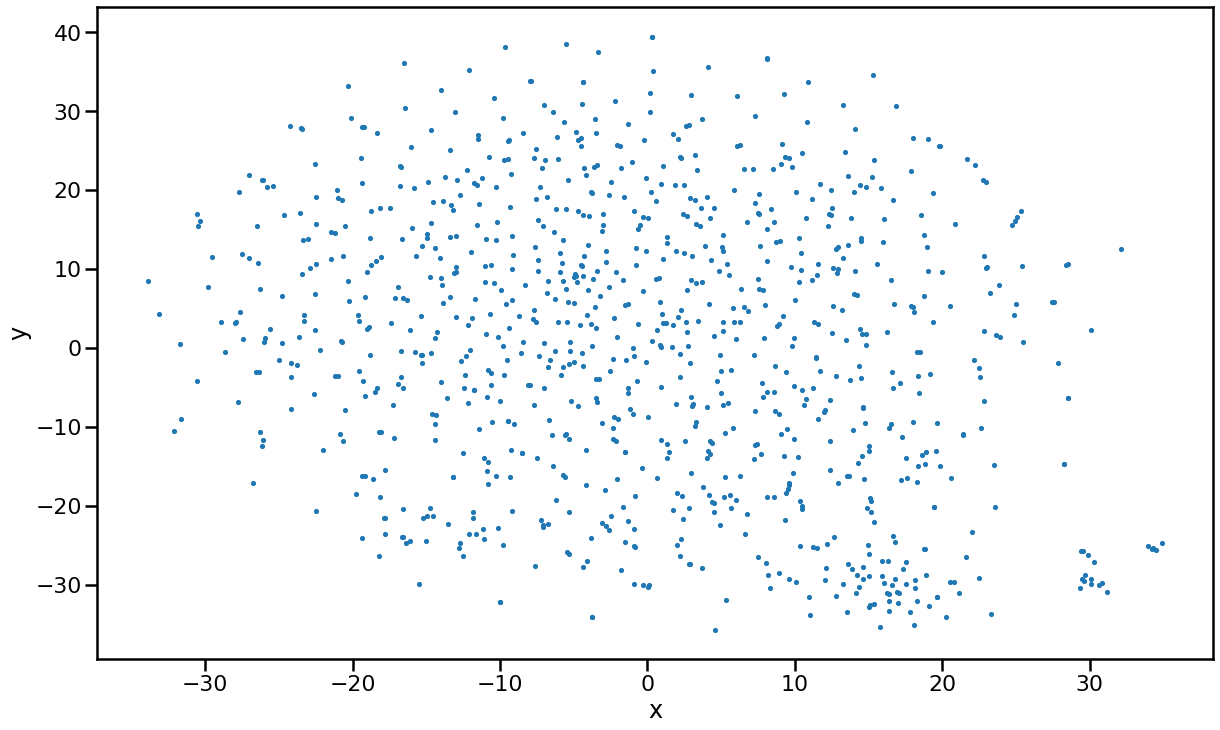

In [44]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

## Zoom in to some interesting places

In [45]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [46]:
# uncomment this code for Chinese texts, there is a glitch with matplotlib, so in order to 
# show embeddings (Chinese characters), we need to change the font at this step
# https://jdhao.github.io/2017/05/13/guide-on-how-to-use-chinese-with-matplotlib/

## import matplotlib as mpl
## font_name = "Droid Sans Fallback"
## mpl.rcParams['font.family']=font_name
## mpl.rcParams['axes.unicode_minus']=False # in case minus sign is shown as box

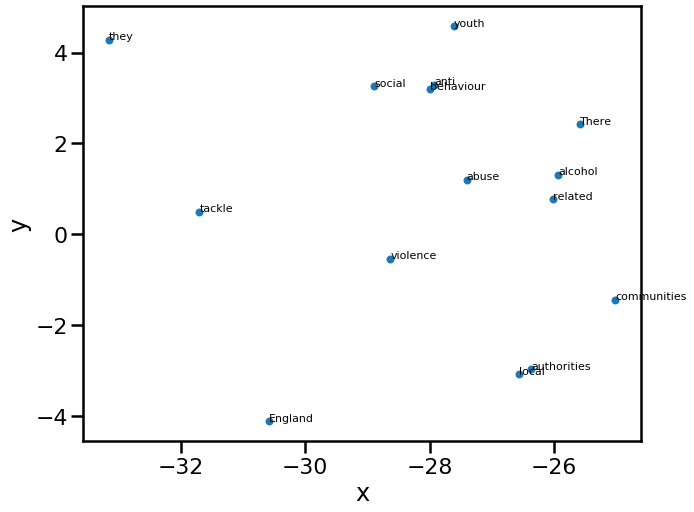

In [47]:
plot_region(x_bounds=(-35.0, -25.0), y_bounds=(-5.0, 5.0))

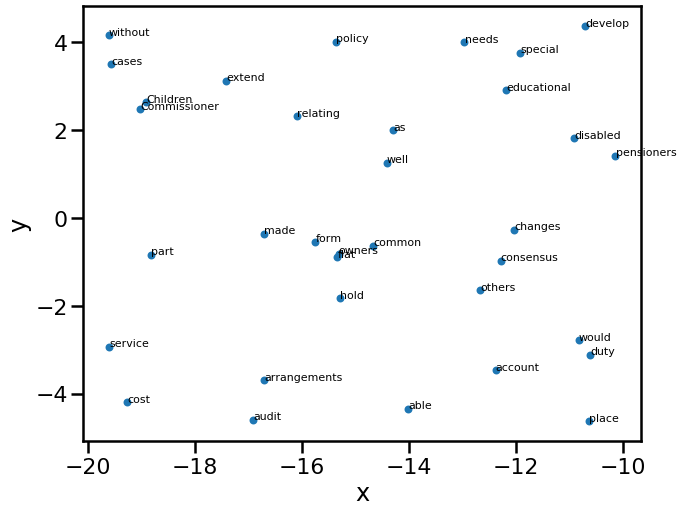

In [48]:
plot_region(x_bounds=(-20.0, -10.0), y_bounds=(-5.0, 5.0))

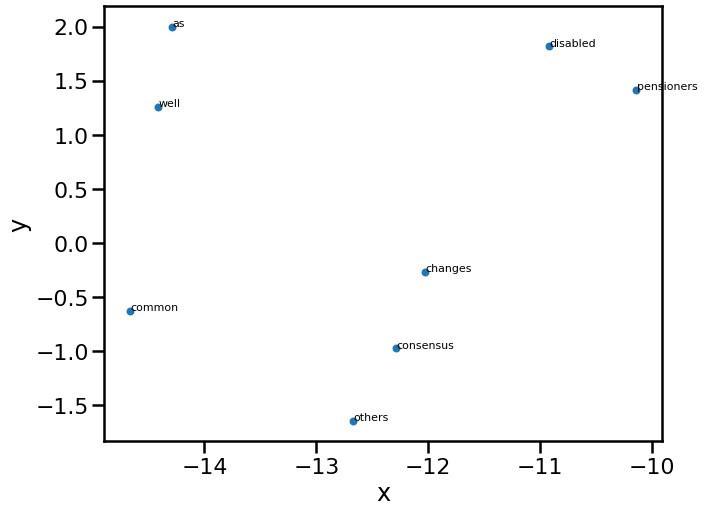

In [49]:
plot_region(x_bounds=(-15.0, -10.0), y_bounds=(-2.5, 2.5))

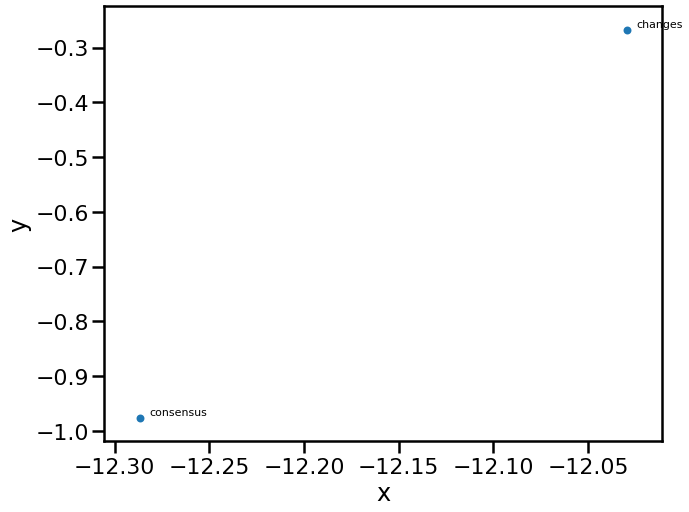

In [52]:
plot_region(x_bounds=(-12.5, -10.0), y_bounds=(-2.5, 0.0))

## Explore semantic similarities between tokens

In [6]:
# Words closest to the given word
thrones2vec.most_similar("development")

[('regeneration', 0.8089592456817627),
 ('expansion', 0.7576152086257935),
 ('growth', 0.7539818286895752),
 ('diversification', 0.7519700527191162),
 ('integration', 0.7408984899520874),
 ('modernization', 0.7232900857925415),
 ('creation', 0.7194961905479431),
 ('modernisation', 0.7188524603843689),
 ('innovation', 0.7143126726150513),
 ('reconstruction', 0.7139564752578735)]

In [7]:
thrones2vec.most_similar("priority")

[('aim', 0.5844428539276123),
 ('objective', 0.5757354497909546),
 ('responsibility', 0.5747633576393127),
 ('requirement', 0.5696966648101807),
 ('profile', 0.5676635503768921),
 ('opportunity', 0.5644316673278809),
 ('status', 0.5583654642105103),
 ('premium', 0.5520043969154358),
 ('consideration', 0.5462216138839722),
 ('prominence', 0.5460208654403687)]

## Linear relationships between word pairs

In [8]:
# distance, similarity, and ranking
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [9]:
nearest_similarity_cosmul("desarrollo", "prioridad", "modernización")

KeyError: "word 'modernización' not in vocabulary"

In [56]:
nearest_similarity_cosmul("presidente", "bienestar", "Rajoy")

presidente is related to bienestar, as ministro is related to Rajoy


/home/fer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """


'ministro'

In [57]:
nearest_similarity_cosmul("presidente", "bienestar", "Zapatero")

presidente is related to bienestar, as Rodríguez is related to Zapatero


/home/fer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """


'Rodríguez'

In [58]:
nearest_similarity_cosmul("podemos", "Podemos", "presidente")

podemos is related to Podemos, as vicepresidente is related to presidente


/home/fer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """


'vicepresidente'

In [59]:
nearest_similarity_cosmul("catalán", "lengua", "español")

catalán is related to lengua, as vasco is related to español


/home/fer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """


'vasco'

In [60]:
nearest_similarity_cosmul("bien", "mejor", "mal")

bien is related to mejor, as Pues is related to mal


/home/fer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """


'Pues'

In [61]:
nearest_similarity_cosmul("Aplausos", "presidente", "Protestas")

Aplausos is related to presidente, as Rumores is related to Protestas


/home/fer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """


'Rumores'

# Visualize word2vec embeddings in TensorBoard

### Create checkpoint (Ctrl + s)

#### Here I had an issue (AttributeError: module 'tensorboard' has no attribute 'lazy')
#### To work around it, I need to use the tensorflowenv, where I have installed Python 3.6 with TF 1.9
#### ... so, it is better since the beginning to just use the tensorflowenv
#### And remember to change the path to the directory path to trained model

In [65]:
# visualise-word2vec
# visualise word embeddings of the word2vec model using Tensorboard

## Video tutorial for this code
## https://www.youtube.com/watch?v=BkeQzJt0f5A&t=2s

import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

# next two imports are commented, as they were imported at the very beginning
import numpy as np
import gensim

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

## Load the saved word2vec model

In [66]:
thrones2vec = "/home/fgbxub/Desktop/W2V-20190719/trained/thrones2vec.w2v"
model = gensim.models.keyedvectors.KeyedVectors.load(thrones2vec)

2019-07-19 04:30:52,726 : INFO : loading Word2VecKeyedVectors object from /home/fgbxub/Desktop/W2V-20190719/trained/thrones2vec.w2v
/home/fgbxub/anaconda3/envs/word2vec/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-07-19 04:30:52,754 : INFO : loading wv recursively from /home/fgbxub/Desktop/W2V-20190719/trained/thrones2vec.w2v.wv.* with mmap=None
2019-07-19 04:30:52,755 : INFO : setting ignored attribute vectors_norm to None
2019-07-19 04:30:52,757 : INFO : loading vocabulary recursively from /home/fgbxub/Desktop/W2V-20190719/trained/thrones2vec.w2v.vocabulary.* with mmap=None
2019-07-19 04:30:52,758 : INFO : loading trainables recursively from /home/fgbxub/Desktop/W2V-20190719/trained/thr

In [67]:
max_size = len(model.wv.vocab)-1

In [68]:
w2v = np.zeros((max_size,model.layer1_size))

/home/fgbxub/anaconda3/envs/word2vec/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `layer1_size` (Attribute will be removed in 4.0.0, use self.trainables.layer1_size instead).
  """Entry point for launching an IPython kernel.


In [69]:
w2v

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [71]:
with open("/home/fgbxub/Desktop/W2V-20190719/trained/metadata.tsv", 'w+') as file_metadata:
    for i,word in enumerate(model.wv.index2word[:max_size]):
        w2v[i] = model.wv[word]
        file_metadata.write(word + '\n')

In [72]:
w2v

array([[-0.39780402,  0.17469235,  0.32568756, ...,  0.1359029 ,
        -0.12251054,  0.02526293],
       [-0.02129346,  0.09115269,  0.11626378, ...,  0.08102056,
        -0.20452486, -0.27921447],
       [ 0.06903911,  0.01301376,  0.16080511, ...,  0.01531295,
         0.01307869, -0.10650862],
       ...,
       [-0.24223521,  0.38291004,  0.08318274, ..., -0.10600892,
        -0.05186681, -0.09988215],
       [-0.092683  ,  0.57307231,  0.04297202, ..., -0.07519681,
         0.08679525, -0.12750451],
       [ 0.06284991,  0.22569154,  0.0887854 , ..., -0.00677922,
         0.04534619,  0.06362052]])

In [73]:
sess = tf.InteractiveSession()

In [74]:
# Let us create a 2D tensor called embedding that holds our embeddings.
with tf.device("/cpu:0"):
    embedding = tf.Variable(w2v, trainable=False, name='embedding')

In [75]:
tf.global_variables_initializer().run()

In [76]:
path = '/home/fgbxub/Desktop/W2V-20190719/trained/'

In [77]:
# Let us create an object to Saver class which is actually used to 
# save and restore variables to and from our checkpoints
saver = tf.train.Saver()

In [78]:
# Using file writer, we can save our summaries and events to our event file.
writer = tf.summary.FileWriter('/home/fgbxub/Desktop/W2V-20190719/trained/', sess.graph)

In [79]:
# Adding into projector
config = projector.ProjectorConfig()
embed = config.embeddings.add()
embed.tensor_name = 'embedding'
embed.metadata_path = 'metadata.tsv'

In [80]:
# Specify the width and height of a single thumbnail.
projector.visualize_embeddings(writer, config)

saver.save(sess, '/home/fgbxub/Desktop/W2V-20190719/trained/model.ckpt', global_step=max_size)

'/home/fgbxub/Desktop/W2V-20190719/trained/model.ckpt-966'

#### To improve results, the upper-case letters in English and Spanish could be converted into lower-case (e.g. so family and Family become the same token).
#### Also I could not find yet a stoplist (.pickle) for Chinese (Chinese is not included in nltk library).
#### Link to "Jupyter notebook cheatsheet" (https://jupyter.brynmawr.edu/services/public/dblank/Jupyter%20Notebook%20Users%20Manual.ipynb#Header-1)

#### Now to activate the TB, fist activate tensorflowenv environment
#### conda activate tensorflowenv

#### and run tensorboard, e.g.
#### (tensorflowenv) tensorboard --logdir=/home/fer/Desktop/word_vector_corpus_ECPC_CD_20190328/trained/

### test with ECPC_CD 2004-2014 on 20190328
### PC specs intel i5 with 8GB RAM (no GPU)
### OS Linux Ubuntu 18.04

#####################
####### 加油！ ########
#####################